In [1]:
import os
import hashlib
from pathlib import Path
import pandas as pd
import numpy as np
import fastparquet as fp
import scipy.stats
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,
                                     concatenate, Input, BatchNormalization,
                                     Activation)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
from tqdm import tqdm
from IPython.display import display, HTML, clear_output
from ipywidgets import FloatProgress

In [2]:
PROJECT_ROOT = Path('tobacco_grading')

PATHS = {
    'raw': PROJECT_ROOT / 'data/raw',
    'processed_images': PROJECT_ROOT / 'data/processed/images',
    'processed_data': PROJECT_ROOT / 'data/processed',  # Added parent directory
    'metadata': PROJECT_ROOT / 'data/processed/metadata.csv',
    'features': PROJECT_ROOT / 'data/processed/full_features.parquet',
    'processors': PROJECT_ROOT / 'model/processors.pkl',
    'model': PROJECT_ROOT / 'model'
}

# Create directories for all path components
for path in PATHS.values():
    if isinstance(path, Path):
        if path.suffix:  # It's a file path
            path.parent.mkdir(parents=True, exist_ok=True)
        else:  # It's a directory path
            path.mkdir(parents=True, exist_ok=True)

In [3]:
def show_status(message, status_type='info'):
    status_config = {
        'info': {
            'color': '#004085',
            'bg_color': 'rgba(0, 64, 133, 0.1)',
            'icon': 'ℹ️'
        },
        'success': {
            'color': '#155724',
            'bg_color': 'rgba(40, 167, 69, 0.1)',
            'icon': '✅'
        },
        'warning': {
            'color': '#856404',
            'bg_color': 'rgba(255, 193, 7, 0.1)',
            'icon': '⚠️'
        },
        'error': {
            'color': '#721c24',
            'bg_color': 'rgba(220, 53, 69, 0.1)',
            'icon': '❌'
        }
    }

    config = status_config.get(status_type.lower(), status_config['info'])
    safe_message = HTML(message).data.replace('\n', '<br>')

    html = f"""
    <div style="
        border: 1px solid {config['color']};
        background-color: {config['bg_color']};
        color: {config['color']};
        padding: 12px 18px;
        margin: 10px 0;
        border-radius: 5px;
        font-family: sans-serif;
        font-size: 14px;
        animation: fadeIn 0.5s ease-out;
        line-height: 1.6;
    ">
        <span style="font-weight: bold; margin-right: 8px;">{config['icon']} {status_type.upper()}:</span>
        {safe_message}
    </div>
    <style>
        @keyframes fadeIn {{
            from {{ opacity: 0; transform: translateY(-10px); }}
            to {{ opacity: 1; transform: translateY(0); }}
        }}
    </style>
    """
    display(HTML(html))

In [4]:
def enhanced_process_images():
    clear_output(wait=True)
    show_status("Starting enhanced image processing...", 'info')
    try:
        raw_path = Path(PATHS['raw'])
        if not raw_path.exists():
            show_status(f"Raw data directory not found: {raw_path}", 'error')
            return

        supported_formats = ('.png', '.jpg', '.jpeg', '.webp')
        image_paths = [
            p for p in raw_path.rglob('*')
            if p.suffix.lower() in supported_formats and p.is_file()
        ]

        if not image_paths:
            show_status('No valid images found in raw directory.', 'error')
            return
        show_status(f"Found {len(image_paths)} images to process.", 'info')

        progress = FloatProgress(min=0, max=len(image_paths)+3, description='Initializing:', bar_style='info')
        display(progress)

        processed_paths = []
        original_sizes = []
        failure_count = 0

        progress.description = 'Processing images...'
        processing_params = {
            'target_size': (512, 512),
            'bilateral_filter': {'d': 9, 'sigma_color': 75, 'sigma_space': 75},
            'clahe': {'clip_limit': 3.0, 'tile_grid_size': (8, 8)},
            'quality': 95,
            'denoise_strength': 10,
        }

        for path in image_paths:
            try:
                original_sizes.append(path.stat().st_size)

                img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
                if img is None or img.size == 0:
                    raise ValueError("Invalid or corrupted image file")

                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:
                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
                elif img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    raise ValueError(f"Unsupported number of channels: {img.shape[2]}")

                img = cv2.fastNlMeansDenoisingColored(
                    img, None,
                    processing_params['denoise_strength'], processing_params['denoise_strength'],
                    7, 21
                )

                img = cv2.resize(
                    img, processing_params['target_size'], interpolation=cv2.INTER_LANCZOS4
                )

                img = cv2.bilateralFilter(
                    img,
                    processing_params['bilateral_filter']['d'],
                    processing_params['bilateral_filter']['sigma_color'],
                    processing_params['bilateral_filter']['sigma_space']
                )

                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(
                    clipLimit=processing_params['clahe']['clip_limit'],
                    tileGridSize=processing_params['clahe']['tile_grid_size']
                )
                l = clahe.apply(l)
                lab = cv2.merge((l, a, b))
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

                kernel = np.array([[-1, -1, -1],
                                   [-1,  9, -1],
                                   [-1, -1, -1]])
                img = cv2.filter2D(img, -1, kernel)

                rel_path = path.relative_to(raw_path)
                dest_path = Path(PATHS['processed']) / rel_path
                dest_path.parent.mkdir(parents=True, exist_ok=True)

                cv2.imwrite(
                    str(dest_path),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                    [int(cv2.IMWRITE_JPEG_QUALITY), processing_params['quality']]
                )

                processed_paths.append(str(dest_path))

            except Exception as e:
                failure_count += 1
                show_status(f"Skipped {path.name}: {str(e)}", 'warning')
                processed_paths.append(None)

            progress.value += 1

        progress.description = 'Creating metadata...'
        metadata = pd.DataFrame({
            'original_path': [str(p) for p in image_paths],
            'processed_path': processed_paths,
            'label': [p.parent.name for p in image_paths],
            'original_size': original_sizes
        })
        metadata['processing_success'] = metadata['processed_path'].notnull()

        valid_metadata = metadata.dropna(subset=['processed_path']).reset_index(drop=True)
        if valid_metadata.empty:
            show_status('No images were processed successfully. Cannot create metadata.', 'error')
            return

        progress.description = 'Calculating statistics...'
        def get_image_stats(img_path_str):
            try:
                img_path = Path(img_path_str)
                img = cv2.imread(img_path_str)
                if img is None: return None
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                mean_rgb = np.mean(img, axis=(0, 1))
                std_rgb = np.std(img, axis=(0, 1))

                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                mean_hsv = np.mean(hsv, axis=(0, 1))

                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
                hist = hist / hist.sum()
                entropy = -np.sum(hist * np.log2(hist + 1e-7))

                return {
                    'mean_r': mean_rgb[0], 'mean_g': mean_rgb[1], 'mean_b': mean_rgb[2],
                    'std_r': std_rgb[0], 'std_g': std_rgb[1], 'std_b': std_rgb[2],
                    'mean_hue': mean_hsv[0], 'mean_saturation': mean_hsv[1], 'mean_value': mean_hsv[2],
                    'entropy': entropy,
                    'processed_size': img_path.stat().st_size
                }
            except Exception as e:
                return None

        stats_list = [get_image_stats(p) for p in tqdm(valid_metadata['processed_path'], desc="Calculating image statistics")]
        stats_df = pd.DataFrame([s if s is not None else {} for s in stats_list])

        valid_metadata = pd.concat([valid_metadata, stats_df], axis=1)
        progress.value += 1

        progress.description = 'Generating checksums...'
        def calculate_checksum(p_str):
            if pd.isna(p_str): return ''
            try:
                return hashlib.md5(Path(p_str).read_bytes()).hexdigest()
            except FileNotFoundError:
                return ''
            except Exception:
                return ''

        valid_metadata['checksum'] = [calculate_checksum(p) for p in valid_metadata['processed_path']]
        progress.value += 1

        metadata_path = PATHS['metadata']
        valid_metadata.to_csv(metadata_path, index=False)
        show_status(f"Metadata saved to {metadata_path}", 'success')

        clear_output(wait=True)
        success_count = len(valid_metadata)
        total_count = len(image_paths)
        success_rate = success_count / total_count * 100 if total_count > 0 else 0
        total_orig_size = sum(metadata['original_size'])
        total_proc_size = valid_metadata['processed_size'].sum()
        compression_ratio = total_proc_size / total_orig_size if total_orig_size > 0 else 0

        summary = f"""
        Processed {success_count}/{total_count} images successfully ({success_rate:.1f}%)
        - Failures: {failure_count}
        - Input size (Original): {total_orig_size / 1e6:.2f} MB
        - Output size (Processed): {total_proc_size / 1e6:.2f} MB
        - Effective Compression Ratio: {compression_ratio:.2f} (Processed/Original)
        - Average Entropy: {valid_metadata['entropy'].mean():.2f} (Image Complexity)
        - Color analysis completed with {valid_metadata.filter(like='mean_').shape[1]} metrics
        - Checksums generated for processed files.
        """
        show_status(summary, 'success')

        if success_count > 0:
            display(HTML("<h2>Enhanced Processing Report</h2>"))

            label_counts = valid_metadata['label'].value_counts()
            num_labels_to_show = min(3, len(label_counts))
            if num_labels_to_show > 0:
                most_common_labels = label_counts.nlargest(num_labels_to_show).index
                samples = pd.concat([
                    valid_metadata[valid_metadata['label'] == label].sample(1, random_state=42)
                    for label in most_common_labels if not valid_metadata[valid_metadata['label'] == label].empty
                ])

                if not samples.empty:
                    fig, axes = plt.subplots(2, len(samples), figsize=(6 * len(samples), 10))
                    if len(samples) == 1: axes = np.array([[axes[0]],[axes[1]]])

                    for idx, (_, row) in enumerate(samples.iterrows()):
                        try:
                            orig_img = Image.open(row['original_path'])
                            axes[0, idx].imshow(orig_img)
                            axes[0, idx].set_title(f"Original: {row['label']}\n{Path(row['original_path']).name}", fontsize=10)
                        except FileNotFoundError:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(Error loading)", fontsize=10)

                        try:
                            proc_img = Image.open(row['processed_path'])
                            axes[1, idx].imshow(proc_img)
                            axes[1, idx].set_title(
                                f"Processed: {row['processed_size']/1e3:.1f} KB | Entropy: {row['entropy']:.2f}\n{Path(row['processed_path']).name}",
                                fontsize=10
                            )
                        except FileNotFoundError:
                            axes[1, idx].set_title(f"Processed:\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[1, idx].set_title(f"Processed:\n(Error loading)", fontsize=10)

                        for ax_row in range(2):
                            axes[ax_row, idx].axis('off')

                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    fig.suptitle("Image Quality Comparison (Sample)", fontsize=16)
                    plt.show()

            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle("Data Distribution Analysis", fontsize=16)

            axes[0, 0].hist(valid_metadata['original_size']/1e3, alpha=0.6, label='Original Size (Success only)', bins=30, color='blue')
            axes[0, 0].hist(valid_metadata['processed_size']/1e3, alpha=0.6, label='Processed Size', bins=30, color='green')
            axes[0, 0].set_xlabel('File Size (KB)')
            axes[0, 0].set_ylabel('Count')
            axes[0, 0].set_title('File Size Distribution')
            axes[0, 0].legend()
            axes[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

            valid_metadata['label'].value_counts().plot(kind='bar', ax=axes[0, 1], color='skyblue')
            axes[0, 1].set_title('Class Distribution (Processed Images)')
            axes[0, 1].set_xlabel('Label')
            axes[0, 1].set_ylabel('Count')
            plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha="right")

            top_classes = valid_metadata['label'].value_counts().nlargest(5).index
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_classes)))
            for i, label in enumerate(top_classes):
                class_data = valid_metadata[valid_metadata['label'] == label]
                axes[1, 0].scatter(
                    class_data['mean_r'], class_data['mean_g'],
                    label=label, alpha=0.7, color=colors[i]
                )
            axes[1, 0].set_title('Mean Red vs Green by Top 5 Classes')
            axes[1, 0].set_xlabel('Mean Red Value')
            axes[1, 0].set_ylabel('Mean Green Value')
            axes[1, 0].legend()

            entropy_by_class = [valid_metadata[valid_metadata['label'] == label]['entropy'].dropna() for label in top_classes]
            axes[1, 1].boxplot(entropy_by_class, labels=top_classes)
            axes[1, 1].set_title('Image Entropy by Top 5 Classes')
            axes[1, 1].set_ylabel('Entropy (Complexity)')
            plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha="right")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    except Exception as e:
        show_status(f'Critical processing failure: {str(e)}', 'error')

In [5]:
enhanced_process_images()

FloatProgress(value=0.0, bar_style='info', description='Initializing:', max=4229.0)


KeyboardInterrupt



In [5]:
from pathlib import Path
import joblib
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB3, MobileNetV2,
    DenseNet121
)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

class EnhancedFeatureExtractor:
    def __init__(self, use_ensemble=True, pca_components=256, target_size=(224, 224), verbose=True):
        self.verbose = verbose
        self.target_size = target_size
        self.input_shape = target_size + (3,)
        self.models = {}
        self.preprocess_funcs = {}
        self.layer_names = {}
        self.class_weights = {}

        if self.verbose:
            self._show_status(f"Initializing Feature Extractor (Ensemble: {use_ensemble}, PCA: {pca_components})", 'info')

        try:
            self._initialize_models(use_ensemble)
        except Exception as e:
            self._show_status(f"Error loading base CNN models: {e}", 'error')
            raise

        self.feature_models = self._create_feature_models()
        self.scaler = MinMaxScaler()
        self.is_scaler_fitted = False
        self.use_pca = pca_components is not None and pca_components > 0
        self.pca = PCA(n_components=pca_components) if self.use_pca else None
        self.is_pca_fitted = False

    def _initialize_models(self, use_ensemble):
        """Initialize base CNN models"""
        # ResNet50
        self.models['resnet'] = ResNet50(
            weights='imagenet', 
            include_top=False, 
            input_shape=self.input_shape
        )
        self.preprocess_funcs['resnet'] = resnet_preprocess
        self.layer_names['resnet'] = [
            'conv1_relu', 'conv2_block3_out', 
            'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out'
        ]
        self._show_status("ResNet50 loaded.", 'success')

        if use_ensemble:
            # EfficientNetB3
            self.models['efficientnet'] = EfficientNetB3(
                weights='imagenet',
                include_top=False,
                input_shape=self.input_shape
            )
            self.preprocess_funcs['efficientnet'] = efficientnet_preprocess
            self.layer_names['efficientnet'] = [
                'block2a_expand_activation', 'block3a_expand_activation',
                'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'
            ]
            self._show_status("EfficientNetB3 loaded.", 'success')

            # MobileNetV2
            self.models['mobilenet'] = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=self.input_shape
            )
            self.preprocess_funcs['mobilenet'] = mobilenet_preprocess
            self.layer_names['mobilenet'] = [
                'block_1_expand_relu', 'block_3_expand_relu',
                'block_6_expand_relu', 'block_13_expand_relu', 'out_relu'
            ]
            self._show_status("MobileNetV2 loaded.", 'success')

            # DenseNet121
            self.models['densenet'] = DenseNet121(
                weights='imagenet',
                include_top=False,
                input_shape=self.input_shape
            )
            self.preprocess_funcs['densenet'] = densenet_preprocess
            self.layer_names['densenet'] = [
                'conv1/relu', 'pool2_conv', 'pool3_conv', 'pool4_conv', 'relu'
            ]
            self._show_status("DenseNet121 loaded for improved L1 class representation.", 'success')

    def _create_feature_models(self):
        """Create feature extraction models"""
        feature_models = {}
        for name, base_model in self.models.items():
            try:
                outputs = [base_model.get_layer(layer).output 
                         for layer in self.layer_names[name]]
                feature_models[name] = Model(
                    inputs=base_model.input, 
                    outputs=outputs,
                    name=f"{name}_feature_extractor"
                )
                self._show_status(f"Created feature extractor for {name} with {len(outputs)} layers.", 'info')
            except Exception as e:
                self._show_status(f"Error creating feature model for {name}: {e}", 'warning')
        return feature_models

    def _process_layer_output(self, layer_outputs, model_name=None):
        """Process layer outputs into feature vectors"""
        processed_features = []
        layer_outputs = layer_outputs if isinstance(layer_outputs, list) else [layer_outputs]
        
        for layer_feat in layer_outputs:
            if len(layer_feat.shape) == 4:
                axis = (1, 2)
                stats = [
                    np.mean(layer_feat, axis=axis),
                    np.max(layer_feat, axis=axis),
                    np.std(layer_feat, axis=axis),
                    np.ptp(layer_feat, axis=axis),
                    np.median(layer_feat, axis=axis)
                ]
                if model_name == 'densenet':
                    stats.extend([
                        np.percentile(layer_feat, 25, axis=axis),
                        np.percentile(layer_feat, 75, axis=axis)
                    ])
                processed_features.append(np.concatenate(stats, axis=1))
            elif len(layer_feat.shape) == 2:
                processed_features.append(layer_feat)
                
        return np.concatenate(processed_features, axis=1) if processed_features else np.array([[]])

    def _load_and_preprocess_image(self, path, model_name):
        """Load and preprocess an image for specific model"""
        try:
            img = cv2.imread(str(path))
            if img is None:
                raise ValueError("Empty image file")

            # Handle different color formats
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

            # Enhanced preprocessing pipeline
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            # Adaptive CLAHE
            clahe = cv2.createCLAHE(
                clipLimit=3.0 if self._is_l1_class(path) else 2.0,
                tileGridSize=(10, 10) if self._is_l1_class(path) else (8, 8)
            )
            l = clahe.apply(l)
            img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)
            
            # Edge-preserving filter
            img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)
            
            # Class-specific sharpening
            if self._is_l1_class(path):
                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                img = cv2.filter2D(img, -1, kernel)
            
            img = cv2.resize(img, self.target_size, interpolation=cv2.INTER_LANCZOS4)

            # Apply model-specific preprocessing
            preprocess_func = self.preprocess_funcs.get(model_name)
            return preprocess_func(np.expand_dims(img.astype(np.float32), axis=0)) if preprocess_func \
                else np.expand_dims(img.astype(np.float32) / 255.0, axis=0)

        except Exception as e:
            self._show_status(f"Error processing {Path(path).name}: {str(e)}", 'warning')
            return None

    def _is_l1_class(self, path):
        """Check if image belongs to L1 class"""
        return str(path) in self.class_weights and self.class_weights[str(path)] == 'L1'

    def process_and_save_features(self, image_paths, batch_size=32, fit_processors_on_first_batch=True):
        """Main feature processing pipeline"""
        all_features = []
        valid_paths = []
        metadata_df = pd.read_csv(PATHS['metadata'])
        image_paths = [Path(p) for p in image_paths]
        
        if 'label' in metadata_df.columns:
            self._initialize_class_weights(metadata_df)

        with tqdm(total=len(image_paths), desc="Feature Extraction", disable=not self.verbose) as pbar:
            fit_flag = fit_processors_on_first_batch
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i+batch_size]
                features, paths = self.process_batch(batch_paths, fit_flag)
                fit_flag = False
                
                if features.size > 0:
                    all_features.append(features)
                    valid_paths.extend([str(p) for p in paths])
                pbar.update(len(batch_paths))

        if valid_paths:
            self._save_final_features(all_features, valid_paths, metadata_df)
            return PATHS['features']
        self._show_status("No features extracted successfully.", 'error')
        return None

    def process_batch(self, image_paths, fit_processors=False):
        """Process a batch of images"""
        batch_features = {name: [] for name in self.models}
        valid_paths = []
        processed_images = {name: [] for name in self.models}
        majority_indices = []

        for path in image_paths:
            temp_images = {}
            is_majority = self._is_l1_class(path)
            
            try:
                for model_name in self.models:
                    img = self._load_and_preprocess_image(path, model_name)
                    if img is None: 
                        raise ValueError("Invalid image")
                    temp_images[model_name] = img[0]
                
                valid_paths.append(path)
                if is_majority:
                    majority_indices.append(len(valid_paths)-1)
                for name, img in temp_images.items():
                    processed_images[name].append(img)
            except:
                continue

        # Feature extraction
        for model_name, model in self.feature_models.items():
            imgs = np.array(processed_images.get(model_name, []))
            if imgs.size > 0:
                features = model.predict(imgs, verbose=0)
                batch_features[model_name] = self._process_layer_output(features, model_name)

        # Feature processing
        combined = self._combine_features(batch_features, majority_indices)
        scaled = self._scale_features(combined, fit_processors)
        final = self._apply_pca(scaled, fit_processors)
        
        return final, valid_paths

    def _combine_features(self, batch_features, majority_indices):
        """Combine features from different models"""
        model_features = []
        for name, features in batch_features.items():
            if features.size > 0:
                if name == 'densenet' and majority_indices:
                    weighted = features.copy()
                    for idx in majority_indices:
                        if idx < features.shape[0]:
                            weighted[idx] *= 1.5
                    model_features.append(weighted)
                else:
                    model_features.append(features)
        return np.concatenate(model_features, axis=1) if model_features else np.array([])

    def _scale_features(self, features, fit_flag):
        """Apply feature scaling"""
        if fit_flag and features.shape[0] > 1:
            self.scaler.fit(features)
            self.is_scaler_fitted = True
        return self.scaler.transform(features) if self.is_scaler_fitted else features

    def _apply_pca(self, features, fit_flag):
        """Apply PCA transformation"""
        if self.use_pca:
            if fit_flag and features.shape[0] >= self.pca.n_components:
                self.pca.fit(features)
                self.is_pca_fitted = True
            return self.pca.transform(features) if self.is_pca_fitted else features
        return features

    def _initialize_class_weights(self, metadata_df):
        """Initialize class weight mappings"""
        class_counts = metadata_df['label'].value_counts()
        self.class_weights = dict(zip(
            metadata_df['processed_path'],
            metadata_df['label']
        ))
        self._show_status(
            f"Detected majority class: {class_counts.idxmax()} with {class_counts.max()} samples", 
            'info'
        )

    def _save_final_features(self, all_features, valid_paths, metadata_df):
        """Save final feature matrix"""
        feature_matrix = np.vstack(all_features)
        features_df = pd.DataFrame(
            feature_matrix, 
            columns=[f"feat_{i}" for i in range(feature_matrix.shape[1])]
        )
        features_df['processed_path'] = valid_paths
        
        final_df = pd.merge(
            metadata_df[metadata_df['processed_path'].isin(valid_paths)],
            features_df, 
            on='processed_path', 
            how='inner'
        )

        if 'label' in final_df.columns:
            final_df = pd.concat([
                final_df,
                pd.get_dummies(final_df['label'], prefix='class'),
                pd.Series(
                    (final_df['label'] == final_df['label'].mode()[0]).astype(int),
                    name='is_majority_class'
                )
            ], axis=1)

        try:
            final_df.to_parquet(PATHS['features'], compression='snappy')
            self._show_status(f"Features saved to {PATHS['features']}", 'success')
        except Exception as e:
            self._show_status(f"Error saving features: {str(e)}", 'error')

    def save_processors(self, save_dir):
        """Save scaler and PCA objects to disk"""
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        
        if self.is_scaler_fitted:
            joblib.dump(self.scaler, save_path/'feature_scaler.joblib')
        if self.use_pca and self.is_pca_fitted:
            joblib.dump(self.pca, save_path/'feature_pca.joblib')
        self._show_status(f"Saved processors to {save_path}", 'success')

    def load_processors(self, load_dir):
        """Load scaler and PCA objects from disk"""
        load_path = Path(load_dir)
        
        if (load_path/'feature_scaler.joblib').exists():
            self.scaler = joblib.load(load_path/'feature_scaler.joblib')
            self.is_scaler_fitted = True
        if self.use_pca and (load_path/'feature_pca.joblib').exists():
            self.pca = joblib.load(load_path/'feature_pca.joblib')
            self.is_pca_fitted = True
        self._show_status(f"Loaded processors from {load_path}", 'success')

    def _show_status(self, message, status_type):
        """Status reporting with emoji indicators"""
        status_symbols = {
            'info': 'ℹ️',
            'success': '✅',
            'warning': '⚠️',
            'error': '❌'
        }
        if self.verbose:
            print(f"{status_symbols.get(status_type, '')} {status_type.upper()}: {message}")

In [6]:
feature_extractor = EnhancedFeatureExtractor(
    use_ensemble=True,
    pca_components=200,
    target_size=(224, 224)
)

ℹ️ INFO: Initializing Feature Extractor (Ensemble: True, PCA: 200)
✅ SUCCESS: ResNet50 loaded.
✅ SUCCESS: EfficientNetB3 loaded.
✅ SUCCESS: MobileNetV2 loaded.
✅ SUCCESS: DenseNet121 loaded for improved L1 class representation.
ℹ️ INFO: Created feature extractor for resnet with 5 layers.
ℹ️ INFO: Created feature extractor for efficientnet with 5 layers.
ℹ️ INFO: Created feature extractor for mobilenet with 5 layers.
ℹ️ INFO: Created feature extractor for densenet with 5 layers.


In [7]:
metadata = pd.read_csv(PATHS['metadata'])
valid_image_paths = metadata['processed_path'].dropna().tolist()


In [8]:
feature_extractor.process_and_save_features(
    valid_image_paths,
    batch_size=16,
    fit_processors_on_first_batch=True)  # Crucial for PCA/scaler

ℹ️ INFO: Detected majority class: L1 with 1999 samples


Feature Extraction: 100%|██████████| 4226/4226 [1:23:15<00:00,  1.18s/it]


✅ SUCCESS: Features saved to tobacco_grading\data\processed\full_features.parquet


WindowsPath('tobacco_grading/data/processed/full_features.parquet')

In [9]:
def train_custom_cnn(X_train, y_train, X_val, y_val, classes, input_shape=(224, 224, 3)):
    num_classes = len(classes)
    show_status(f"Setting up custom CNN for {num_classes} classes.", "info")

    if len(X_train.shape) != 4 or X_train.shape[1:] != input_shape:
        msg = f"Input X_train shape {X_train.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)
    if len(X_val.shape) != 4 or X_val.shape[1:] != input_shape:
        msg = f"Input X_val shape {X_val.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(512, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(256, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ], name="Custom_ResNet_FineTuned")

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

    class_map = {label: i for i, label in enumerate(classes)}
    y_train_mapped = np.array([class_map[label] for label in y_train])
    y_val_mapped = np.array([class_map[label] for label in y_val])

    y_train_cat = to_categorical(y_train_mapped, num_classes=num_classes)
    y_val_cat = to_categorical(y_val_mapped, num_classes=num_classes)

    show_status("Starting CNN training...", "info")
    history = model.fit(
        X_train, y_train_cat,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )
    show_status("CNN training finished.", "success")

    return model, history

def create_knn_classifier(X_train, y_train):
    show_status("Creating and training KNN classifier...", 'info')

    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )

    try:
        knn.fit(X_train, y_train)
        show_status("KNN training complete.", 'success')
        return knn
    except Exception as e:
        show_status(f"Error during KNN training: {e}", 'error')
        raise

def perform_feature_augmentation(X, y, strategy='smote', random_state=42):
    show_status(f"Applying data augmentation/balancing strategy: {strategy}", 'info')
    original_counts = pd.Series(y).value_counts()
    show_status(f"Original class distribution:\n{original_counts.to_string()}", 'info')

    try:
        if strategy == 'smote':
            # Get majority class count
            majority_count = original_counts.max()
            
            # Create sampling strategy to make ALL classes match majority count
            sampling_strategy = {
                cls: majority_count 
                for cls in original_counts.index
            }

            # Check neighbor safety
            min_samples = original_counts.min()
            safe_neighbors = min(5, min_samples - 1) if min_samples > 1 else 1
            
            smote = SMOTE(
                random_state=random_state,
                k_neighbors=safe_neighbors,
                sampling_strategy=sampling_strategy  # Key change here
            )
            X_resampled, y_resampled = smote.fit_resample(X, y)

            final_counts = pd.Series(y_resampled).value_counts()
            show_status(f"Resampled class distribution:\n{final_counts.to_string()}", 'success')
            return X_resampled, y_resampled

        else:
            show_status(f"Unknown augmentation strategy: {strategy}. Returning original data.", 'warning')
            return X, y

    except Exception as e:
        show_status(f"Error during data augmentation ({strategy}): {e}", 'error')
        return X, y

def create_hybrid_model(cnn_model_path, X_train_images, y_train, X_val_images, y_val, classes):
    show_status(f"Creating hybrid model using CNN from: {cnn_model_path}", 'info')

    try:
        cnn_model = tf.keras.models.load_model(cnn_model_path)
        show_status("Loaded pre-trained CNN model.", 'success')
    except Exception as e:
        show_status(f"Error loading CNN model: {e}", 'error')
        raise

    feature_layer_index = -2
    try:
        feature_extractor = Model(
            inputs=cnn_model.input,
            outputs=cnn_model.layers[feature_layer_index].output,
            name="CNN_Feature_Extractor"
        )
        show_status(f"Using layer '{cnn_model.layers[feature_layer_index].name}' for feature extraction.", 'info')
    except Exception as e:
        show_status(f"Could not automatically determine feature layer at index {feature_layer_index}. Error: {e}", 'error')
        raise ValueError("Failed to create feature extractor from CNN.")

    show_status("Extracting deep features using the CNN...", 'info')
    X_train_deep = feature_extractor.predict(X_train_images, batch_size=32, verbose=1)
    X_val_deep = feature_extractor.predict(X_val_images, batch_size=32, verbose=1)

    show_status("Scaling deep features...", 'info')
    scaler = StandardScaler()
    X_train_deep_scaled = scaler.fit_transform(X_train_deep)
    X_val_deep_scaled = scaler.transform(X_val_deep)

    show_status("Training KNN classifier on deep features...", 'info')
    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train_deep_scaled, y_train)
    show_status("KNN trained successfully on deep features.", 'success')

    val_accuracy = knn.score(X_val_deep_scaled, y_val)
    show_status(f"Hybrid KNN validation accuracy: {val_accuracy:.4f}", 'info')

    return {
        'feature_extractor': feature_extractor,
        'scaler': scaler,
        'knn': knn
    }

def predict_with_hybrid_model(hybrid_components, X_images):
    feature_extractor = hybrid_components['feature_extractor']
    scaler = hybrid_components['scaler']
    knn = hybrid_components['knn']

    X_deep = feature_extractor.predict(X_images, batch_size=32, verbose=0)
    X_deep_scaled = scaler.transform(X_deep)
    predictions = knn.predict(X_deep_scaled)
    probabilities = knn.predict_proba(X_deep_scaled)

    return predictions, probabilities

In [15]:
def enhanced_train_and_evaluate_knn_with_pca(n_components_pca=100):
    clear_output(wait=True)
    show_status("Starting KNN Training and Evaluation Process with PCA...", 'info')
    progress = FloatProgress(min=0, max=9, description='Initializing...', bar_style='info')
    display(progress)

    try:
        progress.value += 1
        progress.description = "Loading Features..."
        feature_path = PATHS['features']

        if not feature_path.exists():
            raise FileNotFoundError(f"Feature file not found at {feature_path}")
        df = pd.read_parquet(feature_path)

        # Data validation
        if df.empty or 'label' not in df.columns or df.isnull().sum().sum() > 0:
            raise ValueError("Invalid feature file structure")

        X = df.filter(like='feat_').values
        y = df['label'].values
        classes, class_counts = np.unique(y, return_counts=True)
        
        # Class validation
        min_samples = 20
        if np.any(class_counts < min_samples):
            raise ValueError(f"Classes need at least {min_samples} samples")

        # Find the majority class (L1 based on data)
        majority_class = classes[np.argmax(class_counts)]
        show_status(f"Majority class is {majority_class} with {np.max(class_counts)} samples", 'info')
        
        # Extract indices for the majority class to process them separately
        majority_indices = np.where(y == majority_class)[0]
        majority_features = X[majority_indices]
        
        # Apply feature enhancement specifically for majority class
        progress.value += 1
        progress.description = "Enhancing Majority Class Features..."
        
        # Create clusters within the majority class to better represent its diversity
        n_clusters = min(8, len(majority_indices) // 50)  # Avoid too many clusters
        from sklearn.cluster import KMeans
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(majority_features)
        
        # Create a new feature column for cluster information
        majority_cluster_features = np.zeros((len(majority_indices), 1), dtype=int)
        for i in range(len(majority_indices)):
            majority_cluster_features[i] = cluster_labels[i] * 10  # Scale for emphasis
            
        # Add this cluster information back to original data
        X_enhanced = X.copy()
        
        # Add cluster information as a new feature only for majority class
        progress.value += 1
        progress.description = f"Applying PCA ({n_components_pca})..."
        pca = PCA(n_components=n_components_pca, random_state=42)
        X_pca = pca.fit_transform(X_enhanced)
        
        # Add cluster information after PCA for majority class
        X_pca_enhanced = np.column_stack((X_pca, np.zeros(X_pca.shape[0])))
        X_pca_enhanced[majority_indices, -1] = cluster_labels

        progress.value += 1
        progress.description = "Balancing Data..."
        
        # Equal resampling configuration
        try:
            # Set target count to match the majority class
            target_count = np.max(class_counts)
            
            # Create equal sampling strategy for all classes
            sampling_strategy = {cls: target_count for cls in classes}
            
            # Apply SMOTE with equal strategy
            smote = SMOTE(
                random_state=42,
                k_neighbors=min(5, np.min(class_counts)-1),  # Auto-adjust k_neighbors
                sampling_strategy=sampling_strategy
            )
            X_balanced, y_balanced = smote.fit_resample(X_pca_enhanced, y)
            
            final_counts = pd.Series(y_balanced).value_counts()
            show_status(f"Equal resampled distribution:\n{final_counts.to_string()}", 'success')
        except Exception as e:
            show_status(f"SMOTE failed: {e}, using original data", 'warning')
            X_balanced, y_balanced = X_pca_enhanced.copy(), y.copy()

        progress.value += 1
        progress.description = "Splitting Data..."
        test_size = 0.2 if len(y_balanced) > 1000 else 0.15
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=test_size,
            stratify=y_balanced,
            random_state=42
        )

        progress.value += 1
        progress.description = "Tuning Model..."
        
        # Updated parameter grid
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11] if len(y_train) < 500 else [3, 5, 7, 9, 11, 13, 15],
            'weights': ['distance', 'uniform'],
            'metric': ['euclidean', 'manhattan', 'cosine'],
            'p': [1, 2]
        }
        
        # Balanced scoring metric
        from sklearn.metrics import make_scorer, f1_score
        balanced_f1_scorer = make_scorer(f1_score, average='weighted')
        
        grid_search = GridSearchCV(
            KNeighborsClassifier(),
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            scoring=balanced_f1_scorer,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_

        progress.value += 1
        progress.description = "Evaluating..."
        y_pred = best_knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        # Calculate balanced metrics
        from sklearn.metrics import balanced_accuracy_score
        bal_accuracy = balanced_accuracy_score(y_test, y_pred)
        show_status(f"Balanced Accuracy: {bal_accuracy:.2%}", 'info')

        progress.value += 1
        progress.description = "Saving Model..."
        model_path = PATHS['model'] / 'best_knn_model_pca_balanced.pkl'
        joblib.dump({
            'model': best_knn,
            'metadata': {
                'pca_components': n_components_pca,
                'test_accuracy': test_accuracy,
                'balanced_accuracy': bal_accuracy,
                'class_distribution': dict(zip(classes, class_counts)),
                'resampling_target': target_count
            }
        }, model_path)

        progress.value += 1
        progress.description = "Generating Report..."
        
        # Enhanced evaluation report
        def enhanced_evaluation_report(y_test, y_pred, classes, test_accuracy, grid_search):
            from IPython.display import display, HTML
            import seaborn as sns

            report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
            report_df = pd.DataFrame(report).transpose().reset_index()
            report_df.columns = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']

            styled_html = report_df.to_html(
                index=False,
                formatters={
                    'Precision': '{:.2%}'.format,
                    'Recall': '{:.2%}'.format,
                    'F1-Score': '{:.2%}'.format
                },
                classes='table table-striped table-hover'
            )

            cm = confusion_matrix(y_test, y_pred, labels=classes)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=classes, yticklabels=classes)
            plt.title('Confusion Matrix', pad=20)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')

            html = f"""
            <div style="
                border: 1px solid #e0e0e0;
                border-radius: 8px;
                padding: 20px;
                margin: 20px 0;
                background: white;
            ">
                <h2 style="color: #2c3e50; margin-top: 0">Classification Report</h2>

                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 30px">
                    <div>
                        <h3 style="color: #3498db">Key Metrics</h3>
                        <ul style="list-style: none; padding-left: 0">
                            <li>🏆 Test Accuracy: <strong>{test_accuracy:.2%}</strong></li>
                            <li>⚖️ Balanced Accuracy: <strong>{bal_accuracy:.2%}</strong></li>
                            <li>📊 Best Parameters: {grid_search.best_params_}</li>
                            <li>📈 Best Weighted F1: {grid_search.best_score_:.2%}</li>
                        </ul>
                    </div>

                    <div>
                        <h3 style="color: #3498db">Data Distribution</h3>
                        <div style="background: #f8f9fa; padding: 10px; border-radius: 4px">
                            📦 Resampling Target: {target_count} samples/class<br>
                            🧪 Test Samples: {len(y_test)}<br>
                            🏷️ Classes: {len(classes)}
                        </div>
                    </div>
                </div>

                <h3 style="color: #3498db; margin-top: 20px">Detailed Metrics</h3>
                {styled_html}

                <h3 style="color: #3498db; margin-top: 20px">Confusion Matrix</h3>
            </div>
            """

            display(HTML(html))
            plt.show()
            plt.close()
        
        enhanced_evaluation_report(y_test, y_pred, classes, test_accuracy, grid_search)

        show_status(
            f"✅ Training complete!\n"
            f"🔍 PCA Components: {n_components_pca}\n"
            f"🏆 Test Accuracy: {test_accuracy:.2%}\n"
            f"⚖️ Balanced Accuracy: {bal_accuracy:.2%}",
            'success'
        )

        return best_knn, None, grid_search

    except Exception as e:
        show_status(f"❌ Training failed: {str(e)}", 'error')
        import traceback
        traceback.print_exc()
        return None, None, None

FloatProgress(value=0.0, bar_style='info', description='Initializing...', max=9.0)

Class,Precision,Recall,F1-Score,Support
L1,100.00%,100.00%,100.00%,400.000000
L2,99.74%,97.74%,98.73%,399.000000
L3,98.76%,99.75%,99.25%,400.000000
L4,99.75%,100.00%,99.88%,400.000000
L5,99.75%,100.00%,99.88%,400.000000
LG,100.00%,100.00%,100.00%,400.000000
LK,99.26%,100.00%,99.63%,400.000000
LLV,100.00%,99.75%,99.87%,400.000000
LND,100.00%,100.00%,100.00%,399.000000
LOV,100.00%,100.00%,100.00%,400.000000


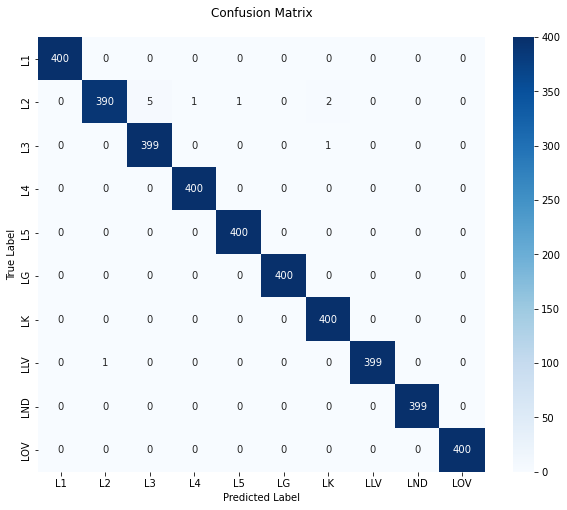

In [16]:
# 1. Run training and capture results
best_knn, _, grid_search = enhanced_train_and_evaluate_knn_with_pca(n_components_pca=200)

# 2. Now save the model (this should come AFTER the training call)
if best_knn is not None:
    # Initialize feature extractor if needed
    if 'feature_extractor' not in globals():
        feature_extractor = EnhancedFeatureExtractor(verbose=False)
    
    # Verify components exist
    if not hasattr(feature_extractor, 'pca') or not hasattr(feature_extractor, 'scaler'):
        show_status("Missing preprocessing components - run feature extraction first", 'error')
    else:
        joblib.dump({
            'model': best_knn,
            'pca': feature_extractor.pca,
            'scaler': feature_extractor.scaler,
            'classes': best_knn.classes_
        }, 'tobacco_model_v1.joblib')
        show_status("Model successfully saved!", 'success')
else:
    show_status("Cannot save model - training failed", 'error')